In [1]:
# 从 google.colab 库中导入 drive 模块
# 这个模块提供了与 Google Drive 交互的功能
from google.colab import drive
# 调用 drive 模块的 mount 方法将 Google Drive 挂载到 Colab 的虚拟机上
# '/content/gdrive' 是挂载的目标路径
# 执行这行代码会弹出一个授权提示，需要用户登录 Google 账号并授权访问 Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# 导入 pandas 库并简写为 pd，用于数据处理和分析
import pandas as pd
# 导入 numpy 库并简写为 np，用于数值计算
import numpy as np
# 导入 matplotlib.pyplot 库并简写为 plt，用于绘制图表
import matplotlib.pyplot as plt
# 导入 seaborn 库并简写为 sns，用于美化图表和统计数据可视化
import seaborn as sns
# 导入 torch 库，这是 PyTorch 深度学习框架的核心库
import torch
# 从 torch.nn 模块导入 nn，用于构建神经网络模型
from torch import nn
# 从 torch.optim 模块导入 optim，用于优化器
from torch import optim
# 从 sklearn.preprocessing 模块导入 MinMaxScaler，用于数据归一化
from sklearn.preprocessing import MinMaxScaler

### 获取数据

In [3]:
# 使用 pandas 的 read_csv 函数读取 CSV 文件到 DataFrame 中
# 文件路径指向 Google Drive 中存储的预处理过的数据文件
new_data = pd.read_csv('/content/gdrive/MyDrive/ElectricPowerTraining/data/new_data.csv')


In [4]:
# 从 new_data DataFrame 中删除不需要的列
# 'Unnamed: 0' 通常是读取CSV时产生的额外索引列
# 'light', 'wind_speed', 'wind_direction_angle', 'weather_status', 'precipitation'
# 这些列可能因为其特征重要性较低而被移除，以简化模型或提高性能
new_data = new_data.drop(['Unnamed: 0', 'light', 'wind_speed', 'wind_direction_angle', 'weather_status', 'precipitation'], axis=1)


In [5]:
# 打印 DataFrame 的信息摘要，包括每列的非空值数量和数据类型，以及内存使用情况
# 用于查看删除列后的数据结构
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75552 entries, 0 to 75551
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   value        75552 non-null  float64
 1   temperature  75552 non-null  float64
 2   humidity     75552 non-null  float64
 3   pressure     75552 non-null  float64
 4   visibility   75552 non-null  float64
 5   holiday      75552 non-null  float64
 6   minute       75552 non-null  float64
 7   week         75552 non-null  float64
 8   year         75552 non-null  float64
dtypes: float64(9)
memory usage: 5.2 MB


In [6]:
# 将整个 new_data DataFrame 的数据类型统一转换为 32 位浮点型 (float32)
# 这样做有助于节省内存并提高PyTorch处理的兼容性
new_data = new_data.astype(np.float32)

In [7]:
# 再次打印 DataFrame 的信息摘要，确认所有列的数据类型都已是 float32
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75552 entries, 0 to 75551
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   value        75552 non-null  float32
 1   temperature  75552 non-null  float32
 2   humidity     75552 non-null  float32
 3   pressure     75552 non-null  float32
 4   visibility   75552 non-null  float32
 5   holiday      75552 non-null  float32
 6   minute       75552 non-null  float32
 7   week         75552 non-null  float32
 8   year         75552 non-null  float32
dtypes: float32(9)
memory usage: 2.6 MB


2021年、2022年、2023年年初电力负荷均出现了明显的先下降后上升过程，但原因不明，需要和电力公司沟通，了解原因。因此在模型训练和测试时选择将这段时间的数据忽略。

删去2021-1-21到2021-2-6，2022-2-9到2022-2-24，2023-1-26到2023-2-13的数据

In [8]:
# 创建一个列表 drop_index，包含需要删除的行索引范围
# 这些索引对应电力负荷异常下降和上升的时间段
drop_index = [i for i in range(1920, 3552)] + [i for i in range(38784, 40320)] + [i for i in range(72480, 74304)]


In [9]:
# 从 new_data DataFrame 中删除指定索引的行
# axis=0 表示按行删除
new_data = new_data.drop(drop_index, axis=0)


In [10]:
# 打印 DataFrame 的信息摘要，查看删除异常数据后的数据总量和结构
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70560 entries, 0 to 75551
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   value        70560 non-null  float32
 1   temperature  70560 non-null  float32
 2   humidity     70560 non-null  float32
 3   pressure     70560 non-null  float32
 4   visibility   70560 non-null  float32
 5   holiday      70560 non-null  float32
 6   minute       70560 non-null  float32
 7   week         70560 non-null  float32
 8   year         70560 non-null  float32
dtypes: float32(9)
memory usage: 3.0 MB


划分训练集和测试集。2021年、2022年前11个月和2023年的数据作为训练集，2022年12月的数据作为测试集

In [11]:
# train1到train5是2021年、2022年前11个月以及2023年的数据，用于训练
train1 = new_data.loc[:1919]
train2 = new_data.loc[3552:38783]
train3 = new_data.loc[40320:67103]
train4 = new_data.loc[70080:72479]
train5 = new_data.loc[74304:]
# 将所有训练集部分拼接起来形成完整的训练集
train = pd.concat([new_data.loc[:67103], new_data.loc[70080:]], axis=0)
# test 是2022年12月的数据，用于测试
test = new_data.loc[67104:70079]


In [12]:
# 打印训练集和测试集的数据行数，确认划分是否正确
print(len(train))
print(len(test))


67584
2976


对训练集和测试集数据归一化

In [13]:
# 实例化 MinMaxScaler，用于将数据缩放到 [0, 1] 范围
scaler = MinMaxScaler()
# 使用完整的训练集数据拟合 MinMaxScaler，计算出数据的最小值和最大值
# fit 方法在这里的本质是根据 train 数据生成归一化所需的min(x)和max(x)
scaler = scaler.fit(train)
# 使用拟合好的 scaler 对训练集的各个部分进行归一化转换
# 结果 train_resultX 是 NumPy 数组 (ndarray) 类型
train_result1 = scaler.transform(train1)  # 结果为ndarray类型
train_result2 = scaler.transform(train2)
train_result3 = scaler.transform(train3)
train_result4 = scaler.transform(train4)
train_result5 = scaler.transform(train5)
# 对测试集数据进行归一化转换，使用训练集相同的 scaler
test_result = scaler.transform(test)

In [14]:
# 显示 scaler 对象本身，它包含了归一化的参数（如 min_、scale_ 等）
scaler


MinMaxScaler()

In [15]:
# 打印归一化后训练集各部分的形状，用于验证转换结果
train_result1.shape


(1920, 9)

In [16]:
train_result2.shape

(35232, 9)

In [17]:
train_result3.shape

(26784, 9)

In [18]:
train_result4.shape

(2400, 9)

In [19]:
train_result5.shape

(1248, 9)

In [20]:
# 打印归一化后测试集的形状，用于验证转换结果
test_result.shape


(2976, 9)

生成训练数据和测试数据

In [21]:
#  可以做个比较，有预测时刻的气象信息与没有预测时刻的气象信息。感觉有预测时刻的气象信息作为输入，模型预测准确性会受到天气预报准确性的影响。
#  生成的样本起始时刻依次相差15分钟
# 定义一个函数 create_inout_sequences，用于生成输入-输出序列
# input_data: 输入的原始数据（已归一化）
# tw: 时间窗口大小 (time window)，这里是768，代表7天的数据点数 (7*96=672) + 24小时 (96)
def create_inout_sequences(input_data, tw):
    # 初始化一个空列表，用于存储生成的输入-输出序列对
    inout_seq = []
    # 获取输入数据的总长度
    L = len(input_data)
    # 循环生成序列，直到数据末尾
    for i in range(L-tw+1):
        # 初始化一个 (96, 15) 的空 NumPy 数组，用于存储单个训练样本的特征
        # 96代表一天96个时刻，15代表每个时刻的特征数量
        train_seq = np.empty((96, 15), dtype=np.float32)
        # 内部循环遍历一天中的96个时刻
        for j in range(96):
            # seq1 提取前7天同一时刻的负荷值（第0列），每隔96个点取一个
            # reshape(-1) 将其展平为一维数组
            seq1 = input_data[i+j:i+tw-96:96, 0].reshape(-1)
            # seq2 提取预测当天同一时刻的除负荷外的其他特征（从第1列开始）
            # i+tw-96+j 定位到预测当天j时刻的数据
            seq2 = input_data[i+tw-96+j, 1:].reshape(-1)
            # 将 seq1 (历史负荷) 和 seq2 (当前时刻特征) 拼接起来，形成每个时刻的特征向量
            seq = np.concatenate((seq1, seq2), axis=0)
            # 将拼接好的特征向量赋值给 train_seq 的第 j 行
            train_seq[j] = seq
        # 提取预测当天96个时刻的负荷值（第0列）作为训练标签
        train_label = input_data[i+tw-96:i+tw, 0]
        # 将输入序列 (train_seq) 和对应的标签 (train_label) 转换为 PyTorch 张量，并作为一个元组添加到列表中
        inout_seq.append((torch.tensor(train_seq) ,torch.tensor(train_label)))
    # 返回所有生成的输入-输出序列对
    return inout_seq

In [22]:
# 调用 create_inout_sequences 函数，使用归一化后的训练集和测试集数据以及时间窗口 768
# 生成用于模型训练和测试的输入-输出序列
train_seq1 = create_inout_sequences(train_result1, 768)
train_seq2 = create_inout_sequences(train_result2, 768)
train_seq3 = create_inout_sequences(train_result3, 768)
train_seq4 = create_inout_sequences(train_result4, 768)
train_seq5 = create_inout_sequences(train_result5, 768)
# 将所有训练部分的序列拼接成一个完整的训练序列列表
train_seq = train_seq1 + train_seq2 + train_seq3 + train_seq4 + train_seq5
# 生成测试序列
test_seq = create_inout_sequences(test_result, 768)


In [23]:
# 打印训练序列列表中包含的序列对的数量
len(train_seq)


63749

In [24]:
# 打印测试序列列表中包含的序列对的数量
len(test_seq)


2209

训练样本的数量为63749，每个训练样本包括特征和标签，其中特征有96个序列，每个序列为前7天同一个时刻的负荷和预测那天同一时刻的数据，时刻从0:00到23:45，标签为预测那天96个时刻的负荷值。

使用前7天和未来24小时的数据预测未来24小时的负荷

设置批量大小为128

In [25]:
# 使用 torch.utils.data.DataLoader 创建训练数据加载器
# train_seq 是要加载的训练数据集
# batch_size=128 设置每个批次包含的样本数量为128
# shuffle=True 表示在每个 epoch 开始时打乱数据，以提高模型泛化能力
trainloader = torch.utils.data.DataLoader(train_seq, batch_size=128, shuffle=True)
# 创建测试数据加载器
# test_seq 是要加载的测试数据集
# batch_size=len(test_seq) 表示将所有测试样本作为一个批次加载（通常用于评估）
testloader = torch.utils.data.DataLoader(test_seq, batch_size=len(test_seq))

In [26]:
# 打印训练数据加载器中的批次数量
len(trainloader)

499

In [27]:
# 打印测试数据加载器中的批次数量 (应该为1，因为batch_size设置为len(test_seq))
len(testloader)

1

In [28]:
# 遍历训练数据加载器的第一个批次，并打印输入 (xb) 和标签 (yb) 的形状
# 用于验证数据批次的结构是否符合预期
for i ,j in trainloader:
    print(i.shape)
    print(j.shape)
    break


torch.Size([128, 96, 15])
torch.Size([128, 96])


In [29]:
# 遍历测试数据加载器的所有批次 (只有一个批次)，并打印输入 (x) 和标签 (y) 的形状
# 用于验证数据批次的结构是否符合预期
for i ,j in testloader:
    print(i.shape)
    print(j.shape)


torch.Size([2209, 96, 15])
torch.Size([2209, 96])


### 建立LSTM模型并训练

In [30]:
# 前7天的负荷数据和未来24小时的数据
# 定义 LSTM 神经网络模型类
class LstmNet(nn.Module):
    # 构造函数，初始化模型的层
    def __init__(self):
        super().__init__() # 调用父类 nn.Module 的构造函数

        # 定义 LSTM 层
        # 输入特征维度为 15 (来自 seq1 和 seq2 的拼接)
        # 隐藏状态维度为 100
        # LSTM 层数为 1
        # batch_first=True 表示输入张量的维度顺序是 (batch_size, sequence_length, input_feature_dim)
        self.layer1 = nn.LSTM(15, 100, 1, batch_first=True)
        # 定义全连接层（线性层）
        # 输入维度为 LSTM 层的输出维度 100
        # 输出维度为 1 (预测单个负荷值)
        self.layer2 = nn.Linear(100, 1)

    # 前向传播函数，定义数据流经模型的路径
    def forward(self, x):
        # x 是输入张量，形状为 (batch_size, 96, 15)
        # y1 是 LSTM 层的输出，_ 是隐藏状态和细胞状态
        # LSTM 的输出 y1 形状为 (batch_size, 96, 100)
        y1, _ = self.layer1(x)
        # y2 是全连接层的输出
        # y1 的每个时间步的输出 (100维度) 都经过全连接层，得到 (batch_size, 96, 1)
        y2 = self.layer2(y1)
        # 将 y2 的形状重塑为 (batch_size, 96)
        # 96代表一天96个时刻的预测负荷值
        return y2.reshape(-1, 96)


In [31]:
# 128*96*15 15*100 128*96*100 100*1 128*96*1 128*96  # 批量大小为128，batch_first=True

In [32]:
# 实例化 LSTM 模型
lstmnet = LstmNet()

In [33]:
# 设置学习率
lr = 0.0001
# 定义优化器为 Adam 优化器
# 将 lstmnet 的所有可学习参数传递给优化器，并指定学习率
opt = optim.Adam(lstmnet.parameters(), lr=lr)


In [34]:
# 这是一个被注释掉的替代学习率设置，可能用于学习率衰减
# opt = optim.Adam(lstmnet.parameters(), lr=lr*0.9)

In [35]:
# 定义损失函数为均方误差损失 (MSELoss)
# 这是回归任务常用的损失函数，计算预测值与真实值之间的平方误差的平均值
loss_function = nn.MSELoss()


In [36]:

# 初始化一个空列表，用于存储每个训练批次的损失值
loss_list = []

In [37]:

# 初始化一个列表，用于存储每个 epoch 结束时在测试集上的 MAPE (平均绝对百分比误差)
# 初始值 3.4174072209639403% 可能来自之前的训练结果，用于比较和判断是否保存模型
MAPE_list = [3.4174072209639403]



In [38]:
# 设置训练的 epoch 数量
epochs = 1 # 这里的设置为1，意味着只进行一个完整的训练周期
for epoch in range(epochs):
    i = 0 # 初始化批次计数器
    # 遍历训练数据加载器中的每个批次
    for xb, yb in trainloader:
        # 将输入数据 xb 传入模型进行前向传播，得到预测值 y
        y = lstmnet(xb)
        # 计算预测值 y 和真实标签 yb 之间的损失
        loss = loss_function(y, yb)
        # 将当前批次的损失值添加到 loss_list 中 (使用 .data 避免跟踪梯度)
        loss_list.append(loss.data)
        # 反向传播计算梯度
        loss.backward()
        # 更新模型参数
        opt.step()
        # 清零梯度，为下一个批次的反向传播做准备
        opt.zero_grad()
        i += 1 # 批次计数器加1
        # 每处理10个批次，打印当前批次的损失值
        if i%10 == 0:
            print(loss.data)

tensor(0.3376)
tensor(0.2615)
tensor(0.2093)
tensor(0.1625)
tensor(0.1244)
tensor(0.0707)
tensor(0.0385)
tensor(0.0226)
tensor(0.0217)
tensor(0.0207)
tensor(0.0189)
tensor(0.0198)
tensor(0.0180)
tensor(0.0198)
tensor(0.0181)
tensor(0.0169)
tensor(0.0207)
tensor(0.0160)
tensor(0.0160)
tensor(0.0180)
tensor(0.0166)
tensor(0.0165)
tensor(0.0177)
tensor(0.0163)
tensor(0.0161)
tensor(0.0155)
tensor(0.0155)
tensor(0.0153)
tensor(0.0151)
tensor(0.0157)
tensor(0.0159)
tensor(0.0142)
tensor(0.0140)
tensor(0.0125)
tensor(0.0147)
tensor(0.0146)
tensor(0.0140)
tensor(0.0143)
tensor(0.0150)
tensor(0.0122)
tensor(0.0146)
tensor(0.0120)
tensor(0.0127)
tensor(0.0123)
tensor(0.0170)
tensor(0.0130)
tensor(0.0115)
tensor(0.0120)
tensor(0.0115)


自己设置的v_max v_min

In [39]:
# 根据训练集数据的 'value' 列计算最大值和最小值
# 这用于后续将归一化的预测结果反归一化回原始尺度
v_max = max(train['value'])
v_min = min(train['value'])
# 遍历测试数据加载器的第一个批次 (通常测试集只有一个大批次)
for x, y in testloader:
    # 将归一化的真实标签 y 反归一化回原始尺度
    true_label = y * (v_max - v_min) + v_min
    # 将反归一化后的真实标签转换为 NumPy 数组
    true_label = true_label.numpy()

In [40]:
# 设置训练的 epoch 数量为 6
epochs = 6
for epoch in range(epochs):
    i = 0 # 初始化批次计数器
    # 遍历训练数据加载器中的每个批次
    for xb, yb in trainloader:
        # 将输入数据 xb 传入模型进行前向传播，得到预测值 y
        y = lstmnet(xb)
        # 计算预测值 y 和真实标签 yb 之间的损失
        loss = loss_function(y, yb)
        # 将当前批次的损失值添加到 loss_list 中 (使用 .data 避免跟踪梯度)
        loss_list.append(loss.data)
        # 反向传播计算梯度
        loss.backward()
        # 更新模型参数
        opt.step()
        # 清零梯度，为下一个批次的反向传播做准备
        opt.zero_grad()
        i += 1 # 批次计数器加1
        # 每处理10个批次，打印当前批次的损失值
        if i%10 == 0:
            print(loss.data)
    print('本轮结束') # 每个 epoch 结束后打印提示信息
    # 在每个 epoch 结束后，对测试集进行评估
    for x, y in testloader:
        # 使用模型对测试集输入进行预测
        pred = lstmnet(x)
        # 将归一化的预测值反归一化回原始尺度
        true_pred = pred * (v_max - v_min) + v_min
        # 将反归一化后的预测值从 PyTorch 张量分离并转换为 NumPy 数组
        true_pred = true_pred.detach().numpy()
        # 计算每个预测点的绝对百分比误差 (APE)
        # APE_array 的形状与 true_pred 和 true_label 相同
        APE_array = abs(true_pred - true_label) / true_label
        # 计算每天的平均 APE (对每个样本的96个时刻求和，然后除以96)
        list1 = (sum(APE_array.T)) / 96
    # 计算测试集所有样本的平均 APE (MAPE)
    rate = sum(list1) / len(list1) * 100
    print(str(rate) + '%') # 打印当前 epoch 的 MAPE
    # 如果当前 epoch 的 MAPE 小于 MAPE_list 中的最小值，则保存模型参数
    if rate < min(MAPE_list):
        # 保存模型的状态字典到指定路径
        torch.save(lstmnet.state_dict(), '/content/gdrive/MyDrive/ElectricPowerTraining/code/lstmnet_2_19')
    # 将当前 epoch 的 MAPE 添加到 MAPE_list 中
    MAPE_list.append(rate)

tensor(0.0112)
tensor(0.0101)
tensor(0.0125)
tensor(0.0114)
tensor(0.0115)
tensor(0.0112)
tensor(0.0105)
tensor(0.0093)
tensor(0.0091)
tensor(0.0099)
tensor(0.0151)
tensor(0.0117)
tensor(0.0092)
tensor(0.0088)
tensor(0.0107)
tensor(0.0083)
tensor(0.0080)
tensor(0.0090)
tensor(0.0086)
tensor(0.0110)
tensor(0.0113)
tensor(0.0086)
tensor(0.0086)
tensor(0.0102)
tensor(0.0118)
tensor(0.0081)
tensor(0.0090)
tensor(0.0089)
tensor(0.0097)
tensor(0.0092)
tensor(0.0102)
tensor(0.0098)
tensor(0.0083)
tensor(0.0081)
tensor(0.0088)
tensor(0.0080)
tensor(0.0098)
tensor(0.0102)
tensor(0.0091)
tensor(0.0085)
tensor(0.0102)
tensor(0.0088)
tensor(0.0082)
tensor(0.0110)
tensor(0.0127)
tensor(0.0109)
tensor(0.0078)
tensor(0.0067)
tensor(0.0075)
本轮结束
6.945928%
tensor(0.0084)
tensor(0.0076)
tensor(0.0072)
tensor(0.0077)
tensor(0.0083)
tensor(0.0063)
tensor(0.0072)
tensor(0.0081)
tensor(0.0076)
tensor(0.0090)
tensor(0.0068)
tensor(0.0107)
tensor(0.0094)
tensor(0.0087)
tensor(0.0063)
tensor(0.0078)
tensor(0.0

尽量使MAPE降到5%以下

### 预测

In [41]:
# 根据训练集数据的 'value' 列重新计算最大值和最小值
# 确保在预测阶段使用与训练和测试数据归一化时相同的v_max和v_min
v_max = max(train['value'])
v_min = min(train['value'])

预测测试集里的某一样本

In [42]:
# 设置 matplotlib 的字体为 'DengXian' (等线)，用于正确显示中文
plt.rc('font',family='DengXian')

In [43]:
# 定义一个函数 picture，用于绘制预测结果图表
# data: 包含输入序列和标签的数据集 (例如 test_seq 或 train_seq)
# index: 要预测的样本在数据集中的索引
def picture(data, index):
    # 使用模型对指定索引的样本进行预测
    # data[index][0] 是该样本的输入特征，形状为 (96, 15)
    # .reshape(1, 96, 15) 将其转换为 (batch_size=1, sequence_length=96, input_feature_dim=15)
    pred = lstmnet(data[index][0].reshape(1, 96, 15))
    # 将归一化的真实标签反归一化回原始尺度
    true_label = data[index][1] * (v_max - v_min) + v_min
    # 将反归一化后的真实标签转换为 NumPy 数组
    true_label = true_label.numpy()
    # 将归一化的预测值反归一化回原始尺度
    true_pred = pred * (v_max - v_min) + v_min
    # 将预测结果重塑为一维数组 (96个预测值)
    true_pred = true_pred.reshape(96)
    # 将反归一化后的预测值从 PyTorch 张量分离并转换为 NumPy 数组
    true_pred = true_pred.detach().numpy()
    # 计算前一个24小时（即前一天）的真实负荷数据
    # data[index-96][1] 提取前一天同一时刻的标签（负荷值）
    before_day = data[index-96][1] * (v_max - v_min) + v_min
    # 将前一天的负荷数据转换为 NumPy 数组
    before_day = before_day.numpy()
 # 创建一个图形，设置图形大小为15x5英寸，DPI为80
    plt.figure(figsize=(15, 5), dpi=80)

    # 生成 X 轴数据，从0到24小时，共96个点（每15分钟一个点）
    X = np.linspace(0, 24, 96, endpoint=True)
    # C代表预测值，S代表真实值，D代表前24小时的负荷
    C,S,D = true_pred, true_label, before_day
    # 绘制预测曲线，蓝色，标签为'预测'
    plt.plot(X, C, color='blue', label='预测')
    # 绘制真实曲线，绿色，标签为'真实'
    plt.plot(X, S, color='green', label='真实')
    # 绘制前24小时负荷曲线，黄色，标签为'前24小时'
    plt.plot(X, D, color='yellow', label='前24小时')
    # 显示图例，放置在左上角
    plt.legend(loc='upper left')
    # 显示图表
    plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21069 (\N{CJK UNIFIED IDEOGRAPH-524D}) missing from font(s) DejaVu Sans.
  fig.canvas

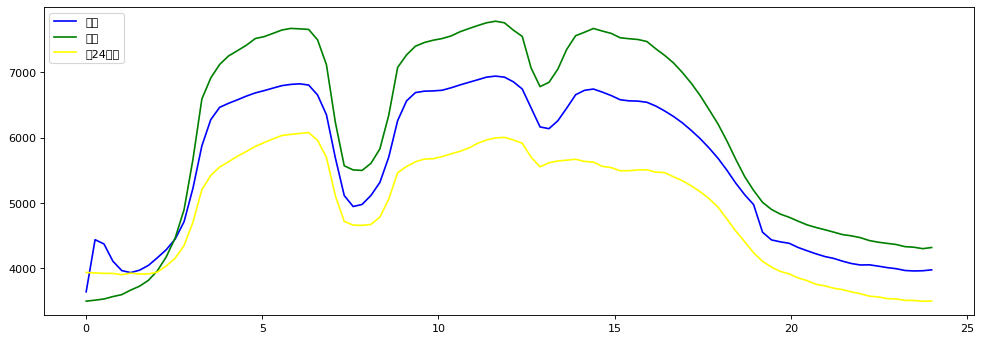

In [44]:
# 调用 picture 函数，预测测试集中的第 500 个样本，并绘制结果图
picture(test_seq, 500)


预测训练集里的某一样本

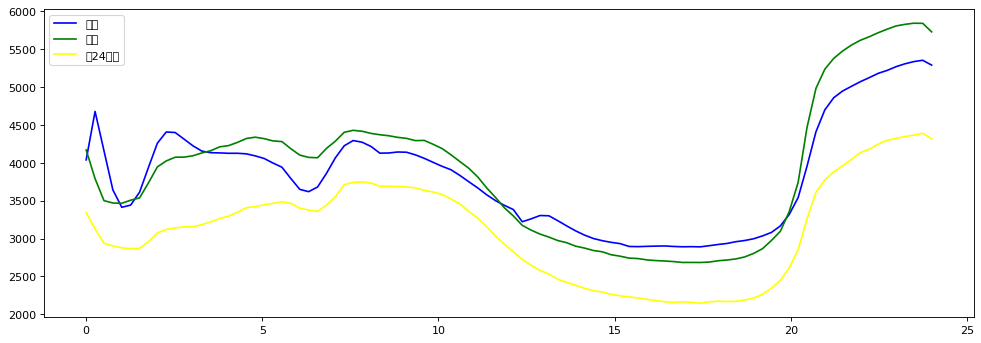

In [45]:
# 调用 picture 函数，预测训练集中的第 6000 个样本，并绘制结果图
picture(train_seq, 6000)

加载训练好的模型参数

In [46]:
# 加载之前训练并保存的模型状态字典
# lstmnet_2_19 是保存模型参数的文件名
lstmnet.load_state_dict(torch.load('/content/gdrive/MyDrive/ElectricPowerTraining/code/lstmnet_2_19'))


<All keys matched successfully>

采用所有样本APE的平均值(mean absolute percentage error)MAPE对模型的预测准确度进行评价

APE（绝对百分比误差）：|y预测 - y真实| ÷ y真实 × 100%

In [47]:
# 重新计算测试集上的 APE
# 遍历测试数据加载器的所有批次 (只有一个批次)
for x, y in testloader:
    # 使用模型进行预测
    pred = lstmnet(x)
    # 将归一化预测值反归一化回原始尺度
    true_pred = pred * (v_max - v_min) + v_min
    # 从 PyTorch 张量分离并转换为 NumPy 数组
    true_pred = true_pred.detach().numpy()
    # 将归一化真实标签反归一化回原始尺度
    true_label = y * (v_max - v_min) + v_min
    # 转换为 NumPy 数组
    true_label = true_label.numpy()
    # 计算每个预测点的绝对百分比误差 (APE)
    APE_array = abs(true_pred - true_label) / true_label
    # 计算每天的平均 APE (对每个样本的96个时刻求和，然后除以96)
    list1 = (sum(APE_array.T)) / 96

In [48]:
# 保存 list1 (每个样本的平均 APE) 到 NumPy 文件
np.save('/content/gdrive/MyDrive/ElectricPowerTraining/code/lstm19_mape', list1)
# 从 NumPy 文件加载 list1 到变量 a，验证保存和加载功能
a = np.load('/content/gdrive/MyDrive/ElectricPowerTraining/code/lstm19_mape.npy')


在测试数据上的MAPE

In [49]:
# 计算并打印测试集上所有样本的平均 APE (MAPE)，以百分比形式显示
str(sum(list1) / len(list1) * 100) + '%'

'4.350708%'

In [50]:
# 打印 MAPE_list 中的最小值
# 这个最小值是在训练过程中保存模型时达到的最低 MAPE
min(MAPE_list)


3.4174072209639403

In [51]:
# 3.4174072209639403%  学习率0.01
# 5.112414281889492%
# 3.3253500115163472%
# 3.509336767145658%
# 3.3265849022677902%
# 2.5648136045817487%
# 3.7180047896266957%
# 2.643353258284469%   学习率0.001
# 3.5444131975630095%
# 2.912302671616746%
# 2.710766884894184%
# 2.6025873555554324%
# 2.489940402945002%
# 2.537331301482852%
# 2.588455757862332%
# 2.3963830265355237%   2_19
# 2.760494189992911%
# 2.5639582831149474%
# 2.526144454767527%
# 2.4566337271037417%  学习率0.0001
# 2.5035853808195125%
# 2.4987265565244994%
# 2.480592684999054%
# 2.4888717922293098%
# 2.446621709097229%
# 2.4527354563694765%
# 2.4554636838288126%
# 2.47179303580078%
# 2.464954966266887%
# 2.5391807137356524%
# 2.4853531681228853%

In [52]:
# 每次训练后若模型在测试集上的损失减小，则保存这次训练的模型，若连续6次训练在测试集上的损失没有小于之前的模型，则将之前的模型作为最终的模型。
# 强制保存当前的 lstmnet 模型的状态字典到指定路径
torch.save(lstmnet.state_dict(), '/content/gdrive/MyDrive/ElectricPowerTraining/code/lstmnet_2_19')


测试数据的APE分布的箱线图

<Axes: >

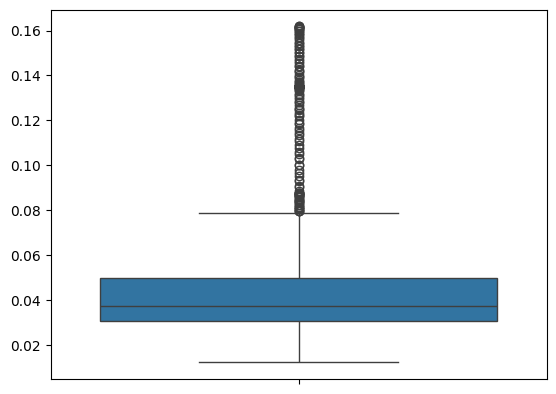

In [53]:
# 使用 seaborn 绘制 list1 (每个样本的平均 APE) 的箱线图
sns.boxplot(data=list1)


(0.0, 0.05)

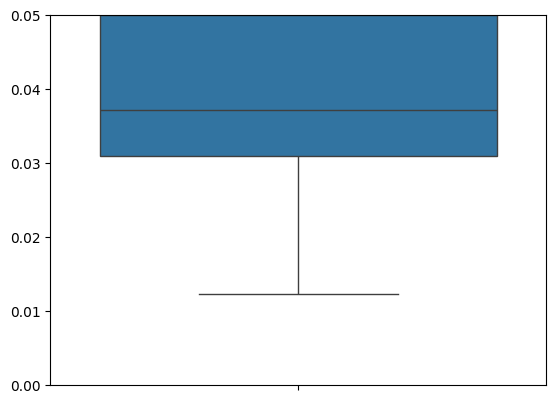

In [54]:
# 再次使用 seaborn 绘制 list1 的箱线图，并设置 Y 轴的显示范围为 0 到 0.05
# 这有助于更清晰地观察 APE 较小部分的分布情况
sns.boxplot(data=list1)
plt.ylim(0, 0.05)


In [55]:
# 打印 list1 中的最小值，即测试数据中单个样本的最小平均绝对百分比误差
min(list1)


np.float32(0.012298112)

In [56]:
# 打印 list1 中的最大值，即测试数据中单个样本的最大平均绝对百分比误差
max(list1)

np.float32(0.16186802)

测试数据的APE分布的折线图

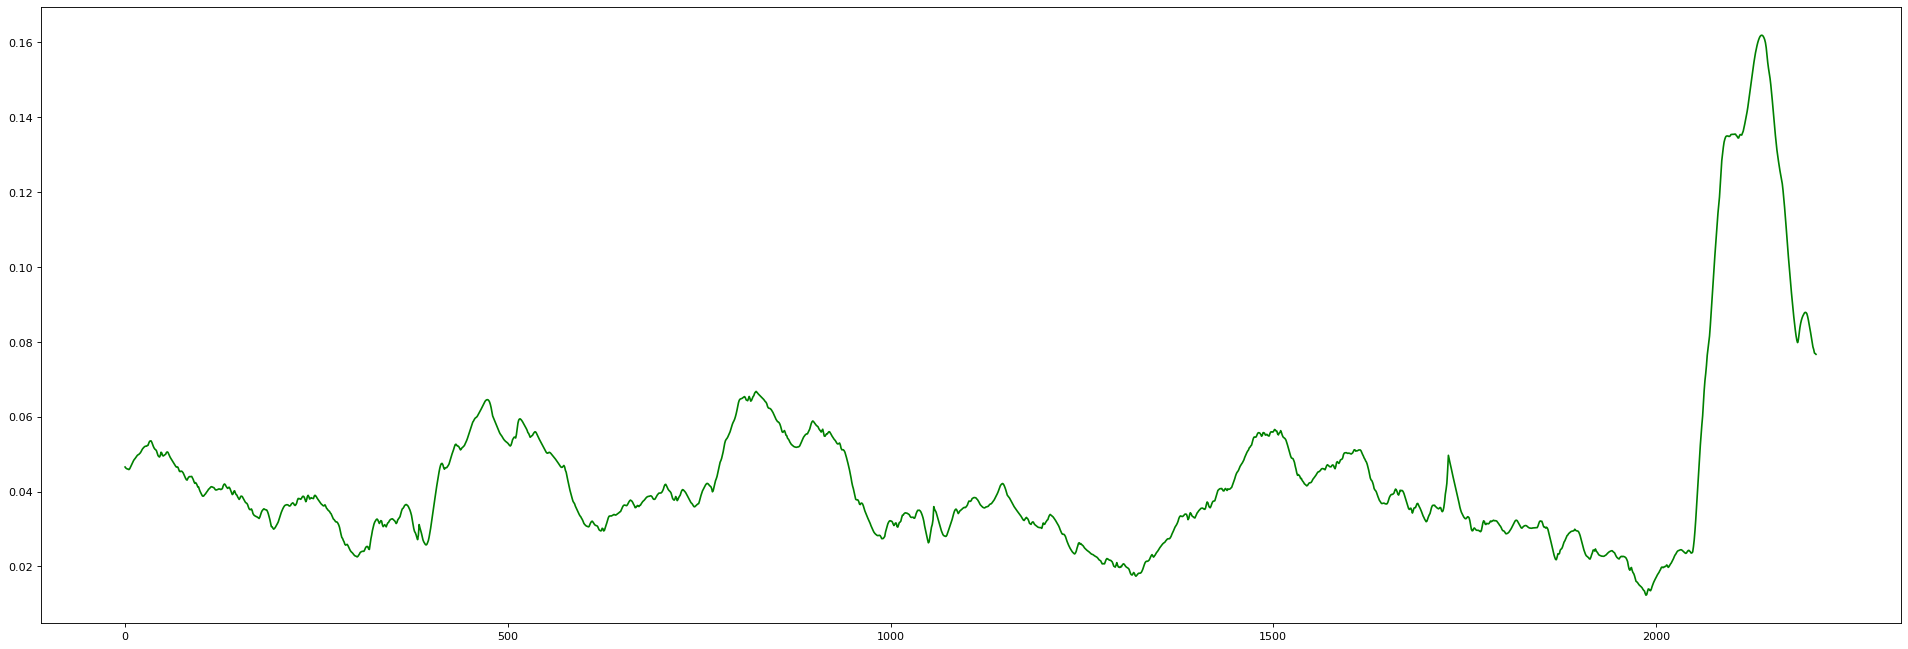

In [57]:
# 创建一个图形，设置图形大小为30x10英寸，DPI为80
plt.figure(figsize=(30, 10), dpi=80)
# 生成 X 轴数据，从0到 list1 的长度，共 len(list1) 个点
X = np.linspace(0, len(list1), len(list1), endpoint=True)
# 绘制 list1 的折线图，颜色为绿色
plt.plot(X, list1, color='green')
# 显示图表
plt.show()

测试数据负荷值的折线图

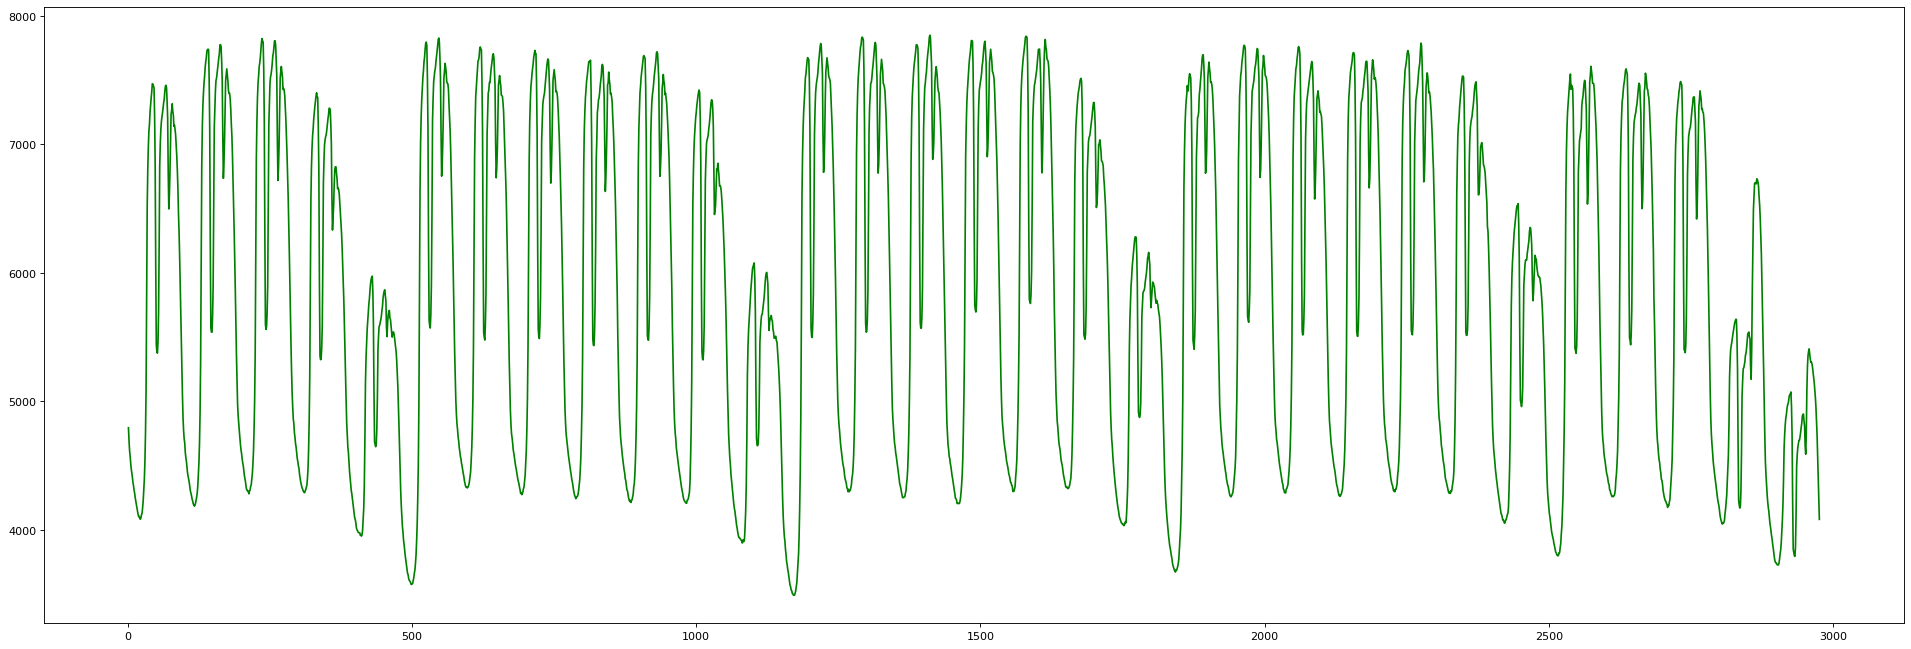

In [58]:
# 创建一个图形，设置图形大小为30x10英寸，DPI为80
plt.figure(figsize=(30, 10), dpi=80)
# 生成 X 轴数据，从1到 test 数据集的长度，共 len(test) 个点
X = np.linspace(1, len(test), len(test), endpoint=True)
# 绘制 test DataFrame 中 'value' 列的折线图，颜色为绿色
# 显示测试集数据的实际负荷值变化趋势
plt.plot(X, test['value'], color='green')
# 显示图表
plt.show()

除去误差较大的预测结果后

In [59]:
# 创建一个新列表 list2，包含 list1 的前2000个元素
# 这意味着只考虑 APE 较小的一部分预测结果，以分析模型在“正常”情况下的表现
list2 = list1[:2000]


In [60]:
# 计算并打印 list2 (去除误差较大结果后) 的平均 APE (MAPE)，以百分比形式显示
str(sum(list2) / len(list2) * 100) + '%'



'3.8451712%'

<Axes: >

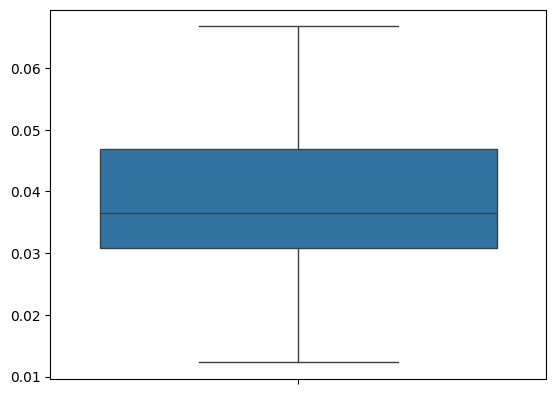

In [61]:

# 使用 seaborn 绘制 list2 的箱线图
# 用于观察去除误差较大结果后的 APE 分布
sns.boxplot(data=list2)

(0.0, 0.05)

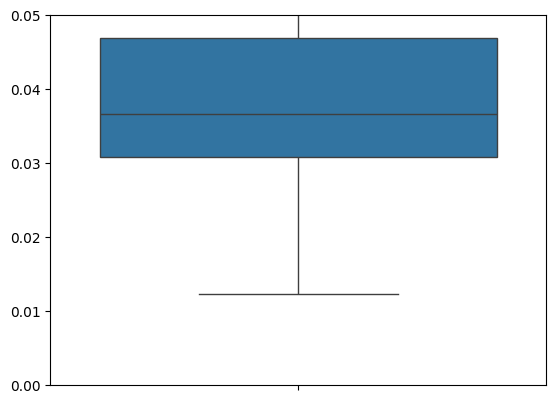

In [62]:
# 再次使用 seaborn 绘制 list2 的箱线图，并设置 Y 轴的显示范围为 0 到 0.05
# 进一步细化观察去除误差较大结果后的 APE 分布
sns.boxplot(data=list2)
plt.ylim(0, 0.05)

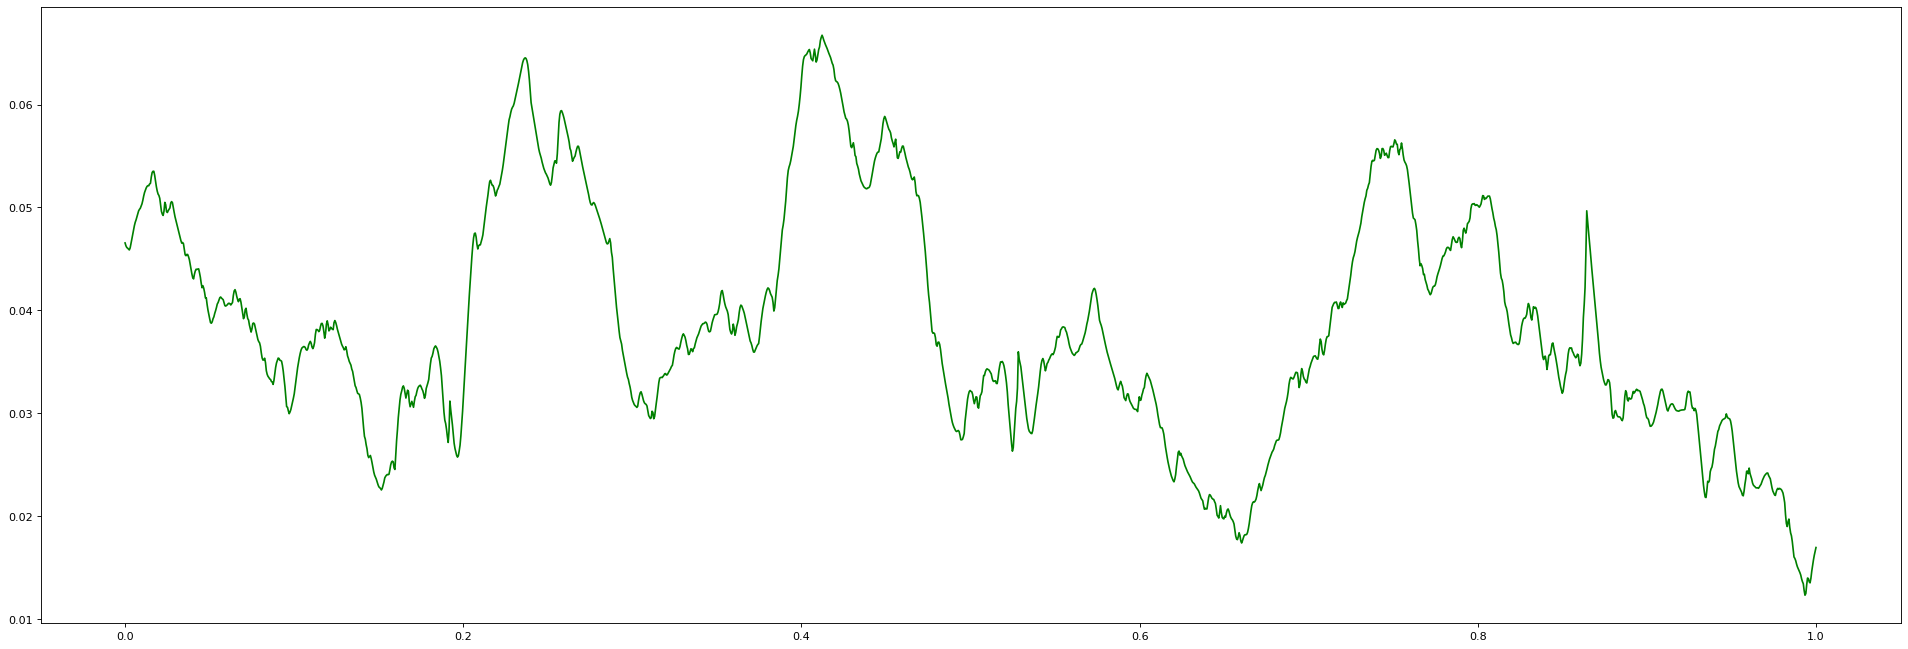

In [63]:
# 创建一个图形，设置图形大小为30x10英寸，DPI为80
plt.figure(figsize=(30, 10), dpi=80)
# 生成 X 轴数据，从0到1 (归一化范围)，共 len(list2) 个点
X = np.linspace(0, 1, len(list2), endpoint=True)
# 绘制 list2 的折线图，颜色为绿色
# 用于可视化去除误差较大结果后的 APE 变化趋势
plt.plot(X, list2, color='green')
# 显示图表
plt.show()


训练过程中在训练集上损失的折线图（以小批量为单位）

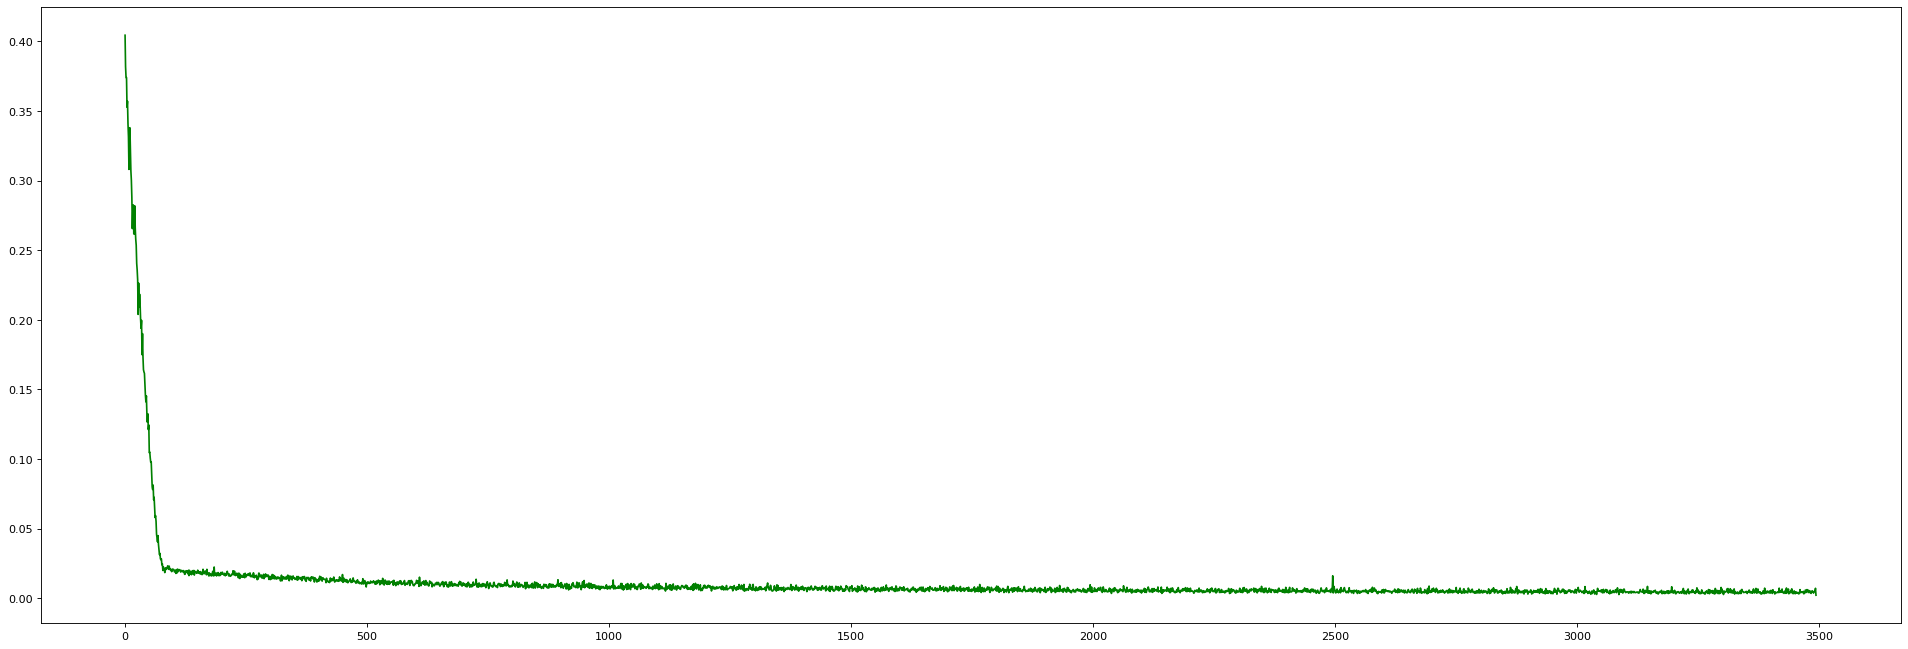

In [64]:

# 创建一个图形，设置图形大小为30x10英寸，DPI为80
plt.figure(figsize=(30, 10), dpi=80)
# 生成 X 轴数据，从1到 loss_list 的长度，共 len(loss_list) 个点
X = np.linspace(1, len(loss_list), len(loss_list), endpoint=True)
# 绘制 loss_list 的折线图，颜色为绿色
# 显示训练过程中损失值的变化趋势
plt.plot(X, loss_list, color='green')
# 显示图表
plt.show()


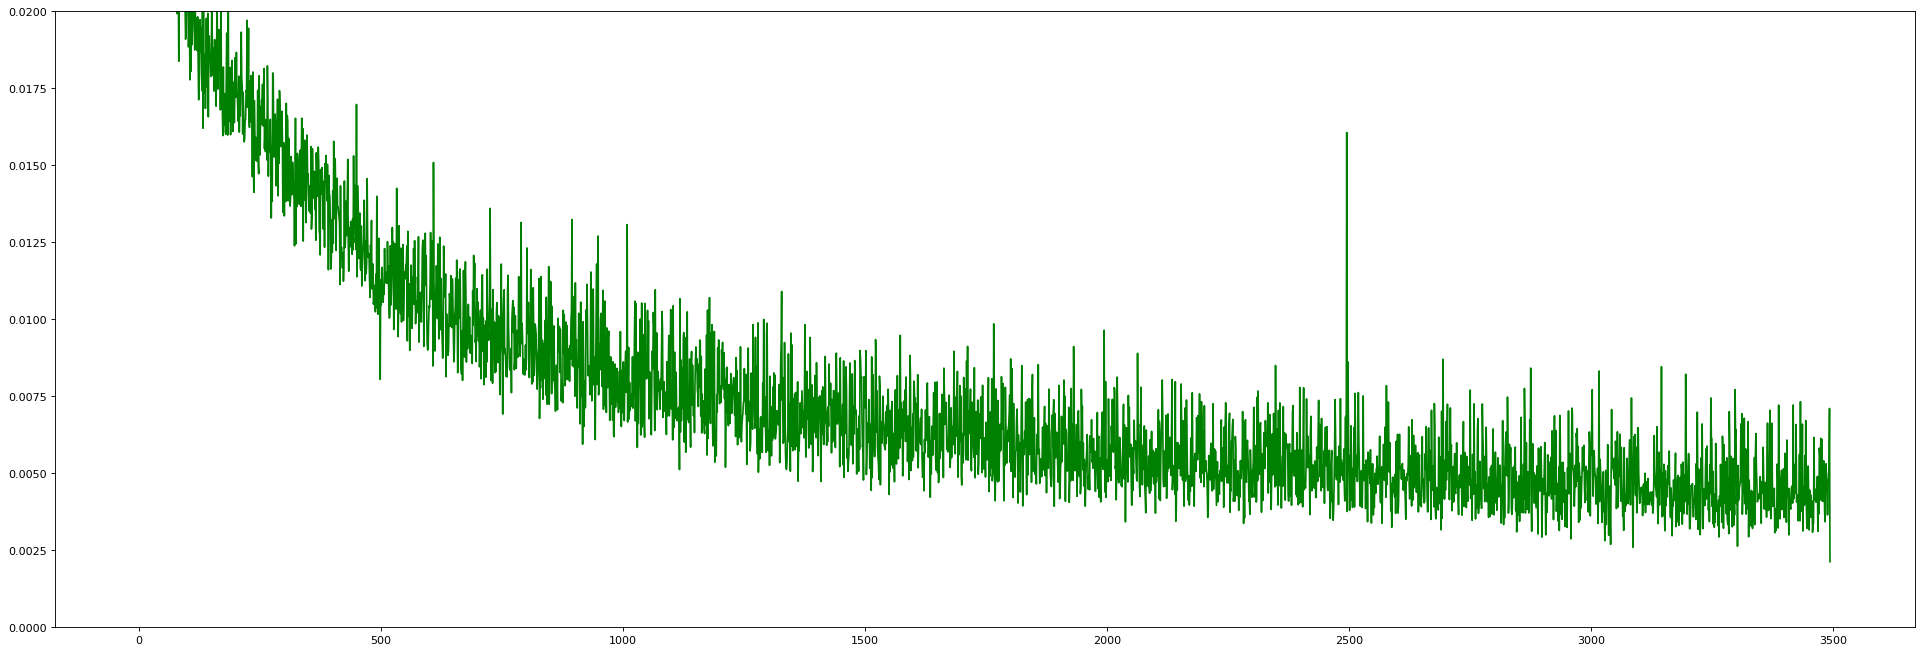

In [65]:
# 创建一个图形，设置图形大小为30x10英寸，DPI为80
plt.figure(figsize=(30, 10), dpi=80)
# 生成 X 轴数据，从1到 loss_list 的长度，共 len(loss_list) 个点
X = np.linspace(1, len(loss_list), len(loss_list), endpoint=True)
# 绘制 loss_list 的折线图，颜色为绿色
# 设置 Y 轴的显示范围为 0 到 0.02，以便更清楚地观察损失值的细节变化
plt.plot(X, loss_list, color='green')
plt.ylim(0,0.02)
# 显示图表
plt.show()

In [66]:
# 保存 loss_list (训练损失) 到 NumPy 文件
np.save('/content/gdrive/MyDrive/ElectricPowerTraining/code/2-19-loss_list.npy', loss_list)
# 从 NumPy 文件加载 loss_list 到变量 a，验证保存和加载功能
a = np.load('/content/gdrive/MyDrive/ElectricPowerTraining/code/2-19-loss_list.npy')


In [67]:
# 考虑将要预测的第一个时刻的特征和预测时刻前24小时的那个时刻的负荷组成一个序列，预测的第二个时刻的特征和预测时刻前24小时的那个时刻的负荷组成
# 一个序列......，最终一个样本有96个序列，分别对应要预测的96个时刻。就像实训2-9那样。
# 考虑新增一个特征：是否为休息日（或工作日），并将节假日的调休去掉。

In [68]:
# 从 NumPy 文件加载不同模型（决策树、全连接神经网络、LSTM-11、LSTM-19）的 MAPE 数据
# 并将它们转换为 Pandas DataFrame
df1 = pd.DataFrame(np.load('/content/gdrive/MyDrive/ElectricPowerTraining/code/tree_mape.npy'), columns=['决策树'])
df2 = pd.DataFrame(np.load('/content/gdrive/MyDrive/ElectricPowerTraining/code/fcnn_mape.npy'), columns=['全连接神经网络'])
df3 = pd.DataFrame(np.load('/content/gdrive/MyDrive/ElectricPowerTraining/code/lstm11_mape.npy'), columns=['LSTM-11'])
df4 = pd.DataFrame(np.load('/content/gdrive/MyDrive/ElectricPowerTraining/code/lstm19_mape.npy'), columns=['LSTM-19'])
# 将这些 DataFrame 沿列方向拼接起来，形成一个包含所有模型 MAPE 数据的总 DataFrame
df = pd.concat([df1, df2, df3, df4], axis=1)

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20915 (\N{CJK UNIFIED IDEOGRAPH-51B3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31574 (\N{CJK UNIFIED IDEOGRAPH-7B56}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26641 (\N{CJK UNIFIED IDEOGRAPH-6811}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20840 (\N{CJK UNIFIED IDEOGRAPH-5168}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36830 (\N{CJK UNIFIED IDEOGRAPH-8FDE}) missing from font(s) DejaVu Sans.
  fig.canvas

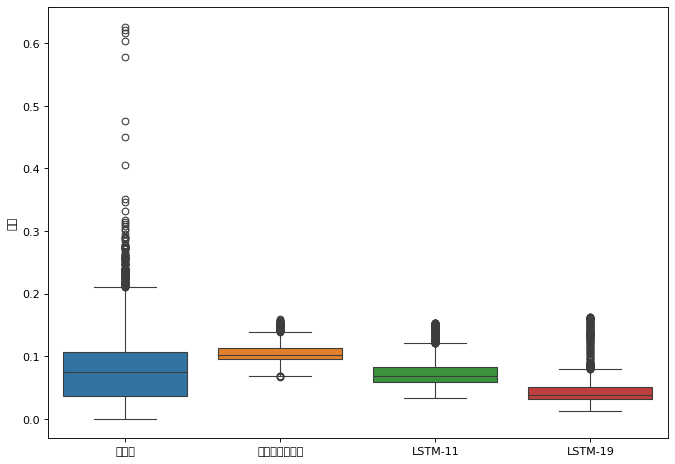

In [69]:
# 创建一个图形，设置图形大小为10x7英寸，DPI为80
plt.figure(figsize=(10,7), dpi= 80)
# 使用 seaborn 绘制 df 中所有模型的 MAPE 分布的箱线图
# 用于比较不同模型的预测误差表现
sns.boxplot(data=df)
# 设置 Y 轴标签为 '误差'
plt.ylabel('误差')
# 显示图表
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20915 (\N{CJK UNIFIED IDEOGRAPH-51B3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31574 (\N{CJK UNIFIED IDEOGRAPH-7B56}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26641 (\N{CJK UNIFIED IDEOGRAPH-6811}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20840 (\N{CJK UNIFIED IDEOGRAPH-5168}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36830 (\N{CJK UNIFIED IDEOGRAPH-8FDE}) missing from font(s) DejaVu Sans.
  fig.canvas

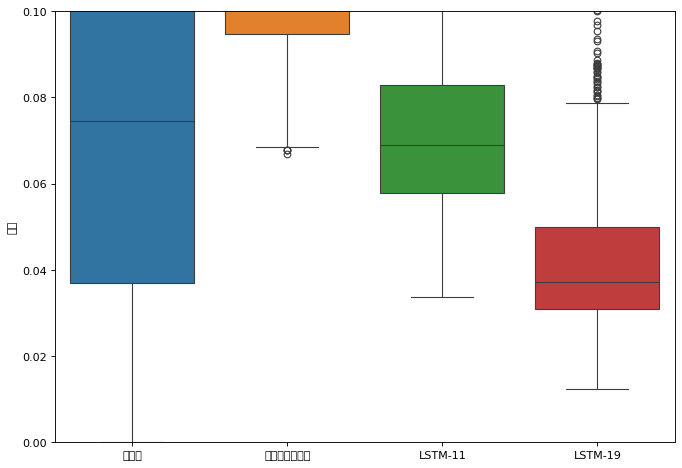

In [70]:
# 创建一个图形，设置图形大小为10x7英寸，DPI为80
plt.figure(figsize=(10,7), dpi= 80)
# 再次使用 seaborn 绘制 df 中所有模型的 MAPE 分布的箱线图
sns.boxplot(data=df)
# 设置 Y 轴的显示范围为 0 到 0.1，以便更清晰地比较误差较小的模型
plt.ylim(0,0.1)
# 设置 Y 轴标签为 '误差'
plt.ylabel('误差')
# 显示图表
plt.show()